In [1]:
from IPython.display import Image

### DQN 구현

- **카트폴 문제(CartPole)**
- 액션은 항상 2가지(왼쪽, 오른쪽으로 밀기)
- 카트의 상태 s는 길이 4인 벡터 / s = (카트의 위치, 카트의 속도, 막대의 각도, 막대의 가속도)

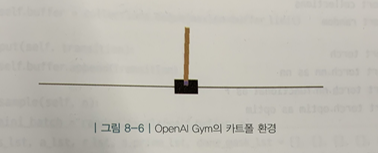

In [2]:
Image('./image/8-1.png')

In [3]:
# 라이브러리 import 
import gym # OpenAI GYM 라이브러리
import collections # deque 활용
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# 하이퍼 파라미터 정의
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32

In [5]:
# 리플레이 버퍼 클래스

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
        
    def put(self, transition):
        self.buffer.append(transition)
        
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], [] 
        # done_mask_lst : 종료 상태의 밸류를 마스킹해주기 위해 만든 변수
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
            
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), torch.tensor(r_lst), \
                torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

In [6]:
# Q밸류 네트워크 클래스

class Qnet(nn.Module): 
    '''
    nn.Module 클래스는 파이토치 라이브러리 안에 포함된 클래스로, 
    뉴럴넷을 만들 때 뼈대가 되는 클래스이며 뉴럴넷과 관련한 다양한 연산을 
    제공해주기 때문에 파이토치에서 뉴럴넷을 선언할 때 거의 디폴트로 상속받는 클래스
    '''
    def __init__(self):
        super(Qnet, self).__init__() 
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()

In [7]:
# 학습 함수

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)
        
        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma*max_q_prime*done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward() # loss에 대한 그라디언트 계산이 일어남
        optimizer.step()

In [8]:
# 메인 함수

def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()
    
    print_interval = 20
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    
    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200))
        # Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime,done_mask))
            s = s_prime
            score += r
            if done:
                break

        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode : {}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
        env.close()

In [ ]:
main()

n_episode : 20, score : 9.8, n_buffer : 195, eps : 7.9%
n_episode : 40, score : 9.8, n_buffer : 392, eps : 7.8%
n_episode : 60, score : 9.7, n_buffer : 585, eps : 7.7%
n_episode : 80, score : 9.7, n_buffer : 779, eps : 7.6%
n_episode : 100, score : 9.8, n_buffer : 974, eps : 7.5%
n_episode : 120, score : 9.6, n_buffer : 1166, eps : 7.4%
n_episode : 140, score : 9.6, n_buffer : 1357, eps : 7.3%
n_episode : 160, score : 9.6, n_buffer : 1549, eps : 7.2%
n_episode : 180, score : 9.7, n_buffer : 1742, eps : 7.1%
n_episode : 200, score : 10.2, n_buffer : 1945, eps : 7.0%
n_episode : 220, score : 11.1, n_buffer : 2166, eps : 6.9%
n_episode : 240, score : 20.8, n_buffer : 2581, eps : 6.8%
n_episode : 260, score : 20.1, n_buffer : 2983, eps : 6.7%
n_episode : 280, score : 19.9, n_buffer : 3381, eps : 6.6%
n_episode : 300, score : 27.8, n_buffer : 3937, eps : 6.5%
n_episode : 320, score : 40.6, n_buffer : 4749, eps : 6.4%
n_episode : 340, score : 65.3, n_buffer : 6055, eps : 6.3%
n_episode : 360